```
Q1 합성곱이 이미지로부터 특징을 추출하는데 사용하는것?
  커널
Q2 합성곱전후로 이미지 크기를 동일하게 만드는데 사용하는 기법
  패딩
Q3 CNN에서 평탄화를 하는 이유
  분류기를 사용
Q4 (225,225) Conv2d(kernel size=3, padding = 0, stride=1)
  223,223
Q5 pooling 을 통과하면
  111,111
Q6 x = (224 224 3) 평탄화 하면 flatten(x, start_dim = 1)
  (224,224*3)
```

ResNet
```
ResNet : 스킵구조를 이용한 CNN
기울기 소실 : 은닉층이 깊어져서  가중치들의 기울기가 0에 가까워지는 현상 - 더이상 업데이트 안됨
학습도중에 파악하기 어려움(기울기소실되었는지 학습이 잘되서 최적의 값에 수렴한것인지)

배치정규화 : 배치간의 차이를 정규화해서 학습을 더 안정적으로

스킵커넥션 : 은닉층을 거치지 않고 입력값과 은닉층의 결과를 더하는 구조

데이터 : CIAR10

```

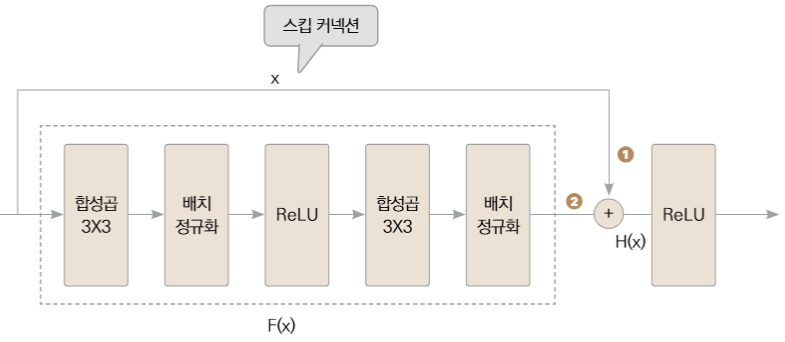

배치정규화

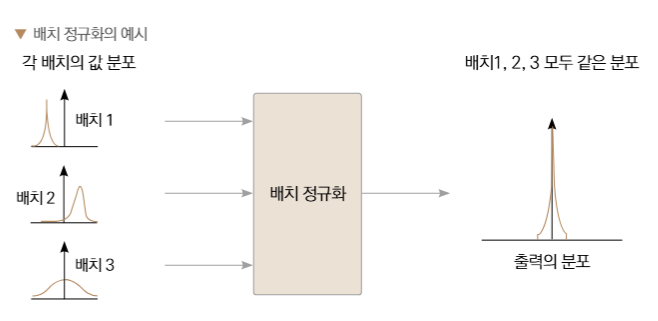

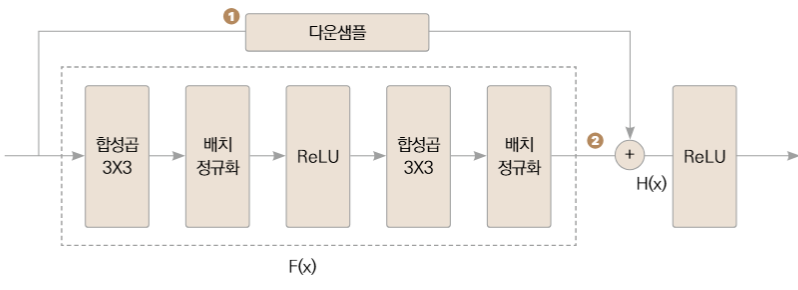

In [ ]:
import torch
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=3):
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,padding=1)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=kernel_size,padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.downsample = nn.Conv2d(in_channels,out_channels,kernel_size=1)
  def forward(self,x):
    x_ = x  # 스킵커넥션을 위해 값을 복사
    x = self.bn1(self.conv1(x))
    x = self.relu(x)
    x = self.bn2(self.conv2(x))
    x_ = self.downsample(x_)  # 최종 cnn과 출력 채널을 맞추기 위해서
    x += x_
    return self.relu(x)

ResNet  구조의 CNN 설계

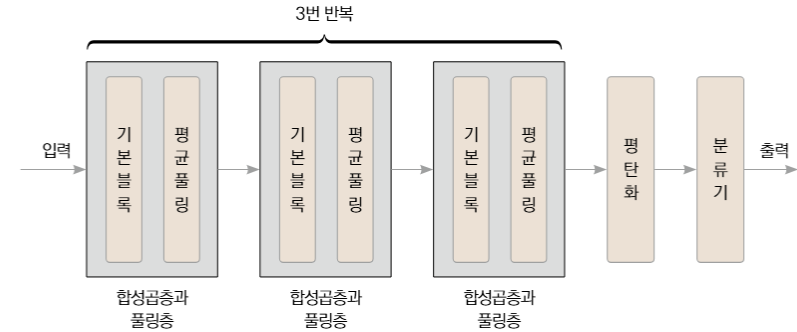

In [ ]:
# !pip uninstall sympy -y
# !pip install sympy --upgrade

In [ ]:
import torch
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=3):
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,padding=1)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=kernel_size,padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.downsample = nn.Conv2d(in_channels,out_channels,kernel_size=1)
  def forward(self,x):
    x_ = x  # 스킵커넥션을 위해 값을 복사
    x = self.bn1(self.conv1(x))
    x = self.relu(x)
    x = self.bn2(self.conv2(x))
    x_ = self.downsample(x_)  # 최종 cnn과 출력 채널을 맞추기 위해서
    x += x_
    return self.relu(x)

In [ ]:
class HResNet(nn.Module):
  def __init__(self, num_classes=1000):
    super(HResNet, self).__init__()
    self.b1 = BasicBlock(3,64)  #  64,32,32
    self.b2 = BasicBlock(64,128)  # 128 32 32
    self.b3 = BasicBlock(128,256) # 256 32 32 (256 4 4)
    self.pool = nn.AvgPool2d(kernel_size=2,stride=2)
    # 분류기  Linear
    self.fc1 = nn.Linear(in_features = 256*4*4 , out_features = 2048)  # 4096
    self.fc2 = nn.Linear(in_features = 2048 , out_features = 512)
    self.fc3 = nn.Linear(in_features = 512 , out_features =10 )
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.pool(self.b1(x)) # (64 16 16)
    x = self.pool(self.b2(x)) # (128 8 8)
    x = self.pool(self.b3(x)) # (256 4 4)
    # 평탄화
    x = torch.flatten(x,start_dim=1)  # (N,256,4,4) --> 256*4*4
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    return self.fc3(x)

# 데이터 가져오기

In [ ]:
from torchvision.datasets.cifar import CIFAR10  # 자체 데이터셋을 만들어서 리턴
from torch.utils.data import DataLoader
from torchvision.transforms import Compose,ToTensor,Normalize
transforms = Compose([ToTensor(),Normalize(mean=(0.5,0.5,0.5), std=(0.25,0.25,0.25))])
cifar10_train_dataset = CIFAR10(root='./',train=True,download=True,transform=ToTensor())
cifar10_test_dataset = CIFAR10(root='./',train=True,download=True,transform=ToTensor())
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=128, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=128)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hresnet = HResNet().to(device)
lr = 1e-4
epochs = 30
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hresnet.parameters(),lr=lr)
for epoch in range(epochs):
  epoch_loss = 0.0
  iterator =  tqdm(cifar10_train_loader)
  for data, label in iterator:
    data, label  = data.to(device), label.to(device)  # 데이터를 device로 전송
    # 예측값
    predict =  hresnet(data)
    # 손실값  - 각 계산과정별 미분수치가 계산 - 계산그래프
    loss = loss_fn(predict, label)
    # 역전파
    loss.backward()
    # 가중치 갱신
    optimizer.step()
    # 가중치 초기화
    optimizer.zero_grad()
    epoch_loss += loss.item()
    iterator.set_description(f'loss : {loss.item()}')
  print(f'epoch:{epoch+1} loss : {epoch_loss/len(cifar10_train_loader)}' )

loss : 0.9230881929397583: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]


epoch:1 loss : 1.230913398820726


loss : 0.8091973066329956: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s]


epoch:2 loss : 0.7972136324323962


loss : 0.42751359939575195: 100%|██████████| 391/391 [00:20<00:00, 19.01it/s]


epoch:3 loss : 0.6137375239368594


loss : 0.3253873884677887: 100%|██████████| 391/391 [00:20<00:00, 19.04it/s]


epoch:4 loss : 0.49022667144265625


loss : 0.41528329253196716: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]


epoch:5 loss : 0.3873258464019317


loss : 0.16434508562088013: 100%|██████████| 391/391 [00:20<00:00, 18.92it/s]


epoch:6 loss : 0.2972310209060874


loss : 0.34960228204727173: 100%|██████████| 391/391 [00:20<00:00, 19.05it/s]


epoch:7 loss : 0.21950296310665052


loss : 0.14835770428180695: 100%|██████████| 391/391 [00:20<00:00, 18.91it/s]


epoch:8 loss : 0.15353909763686188


loss : 0.0776904746890068: 100%|██████████| 391/391 [00:20<00:00, 19.15it/s]


epoch:9 loss : 0.10518740370983967


loss : 0.16623421013355255: 100%|██████████| 391/391 [00:20<00:00, 18.88it/s]


epoch:10 loss : 0.08185148252950758


loss : 0.09339997917413712: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]


epoch:11 loss : 0.06276702914444153


loss : 0.07778671383857727: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]


epoch:12 loss : 0.05433193100925983


loss : 0.045658327639102936: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s]


epoch:13 loss : 0.049427108541416846


loss : 0.10745849460363388: 100%|██████████| 391/391 [00:20<00:00, 18.80it/s]


epoch:14 loss : 0.04550679834783458


loss : 0.006333255674690008: 100%|██████████| 391/391 [00:20<00:00, 18.92it/s]


epoch:15 loss : 0.04055583244308715


loss : 0.027255719527602196: 100%|██████████| 391/391 [00:20<00:00, 19.20it/s]


epoch:16 loss : 0.04115909125174746


loss : 0.02120262198150158: 100%|██████████| 391/391 [00:20<00:00, 18.78it/s]


epoch:17 loss : 0.03128696826127027


loss : 0.009563105180859566: 100%|██████████| 391/391 [00:20<00:00, 18.88it/s]


epoch:18 loss : 0.03158072406923889


loss : 0.038412678986787796: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]


epoch:19 loss : 0.03429758862373145


loss : 0.1405031830072403: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]


epoch:20 loss : 0.02527705073276835


loss : 0.005856387782841921: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]


epoch:21 loss : 0.03789507558621714


loss : 0.059920478612184525: 100%|██████████| 391/391 [00:20<00:00, 18.89it/s]


epoch:22 loss : 0.0229072935016983


loss : 0.06832918524742126: 100%|██████████| 391/391 [00:20<00:00, 18.95it/s]


epoch:23 loss : 0.022546220897420612


loss : 0.029648199677467346: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]


epoch:24 loss : 0.028927898191063263


loss : 0.029845232143998146: 100%|██████████| 391/391 [00:21<00:00, 18.62it/s]


epoch:25 loss : 0.02479479348113108


loss : 0.06585152447223663: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s]


epoch:26 loss : 0.023496358212657616


loss : 0.004821178503334522: 100%|██████████| 391/391 [00:20<00:00, 18.76it/s]


epoch:27 loss : 0.023938848829978262


loss : 0.04435628652572632: 100%|██████████| 391/391 [00:20<00:00, 18.73it/s]


epoch:28 loss : 0.020139272098609336


loss : 0.0009958787122741342: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s]


epoch:29 loss : 0.0227614920812628


loss : 0.007917763665318489: 100%|██████████| 391/391 [00:20<00:00, 19.08it/s]

epoch:30 loss : 0.01334524078159462


# 평가

In [ ]:
hresnet.eval()
total_corr = 0
with torch.no_grad():
  for data, label in cifar10_test_loader:
    data, label = data.to(device), label.to(device)
    predict = hresnet(data)
    pred = predict.data.max(dim=1)[1]
    corr = pred.eq(label).sum().item()
    total_corr += corr
print(f'accuracy : {total_corr / len(cifar10_test_loader.dataset)}')

accuracy : 0.99568


# 추론

In [ ]:
data, label =  next(iter(cifar10_test_loader))
data,label = data.to(device), label.to(device)
hresnet.eval()
predict = hresnet(data)
predict.max(dim=1)[1].eq(label).sum().item() / len(label)

0.9921875

# 전이 학습

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'
res18 = resnet18(ResNet18_Weights)
res18.to(device)
# 마지막 분류층을 수정
res18.fc = nn.Linear(in_features=512, out_features=10, bias=True)
res18.to(device)
# 전체 가중치를 고정하고 fc층만 풀기
for param in res18.parameters():
  param.requires_grad = False
for param in res18.fc.parameters():
  param.requires_grad = True

lr = 1e-4
epochs = 30
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res18.parameters(),lr=lr)
for epoch in range(epochs):
  epoch_loss = 0.0
  iterator =  tqdm(cifar10_train_loader)
  for data, label in iterator:
    data, label  = data.to(device), label.to(device)  # 데이터를 device로 전송
    # 예측값
    predict =  res18(data)
    # 손실값  - 각 계산과정별 미분수치가 계산 - 계산그래프
    loss = loss_fn(predict, label)
    # 역전파
    loss.backward()
    # 가중치 갱신
    optimizer.step()
    # 가중치 초기화
    optimizer.zero_grad()
    epoch_loss += loss.item()
    iterator.set_description(f'loss : {loss.item()}')
  print(f'epoch:{epoch+1} loss : {epoch_loss/len(cifar10_train_loader)}' )

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


NameError: name 'cifar10_train_loader' is not defined

# 평가

In [ ]:
res18.eval()
total_corr = 0
with torch.no_grad():
  for data, label in cifar10_test_loader:
    data, label = data.to(device), label.to(device)
    predict = res18(data)
    pred = predict.data.max(dim=1)[1]
    corr = pred.eq(label).sum().item()
    total_corr += corr
print(f'accuracy : {total_corr / len(cifar10_test_loader.dataset)}')

accuracy : 0.48734


# 추론

In [ ]:
data, label =  next(iter(cifar10_test_loader))
data,label = data.to(device), label.to(device)
res18.eval()
predict = res18(data)
predict.max(dim=1)[1].eq(label).sum().item() / len(label)

0.453125

In [ ]:
# 리사이즈로 224 224 만들고
# 전체가중치를 업데이트
from torchvision.datasets.cifar import CIFAR10  # 자체 데이터셋을 만들어서 리턴
from torch.utils.data import DataLoader
from torchvision.transforms import Compose,ToTensor,Normalize,Resize
transforms = Compose([
    ToTensor(),Normalize( mean=(0.5,0.5,0.5)
  ,std=(0.25,0.25,0.25)), Resize( (224,224) )
    ])
cifar10_train_dataset = CIFAR10(root='./',train=True,download=True,transform=transforms)
cifar10_test_dataset = CIFAR10(root='./',train=False,download=True,transform=transforms)
cifar10_train_loader = DataLoader(cifar10_train_dataset,batch_size=128,shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset,batch_size=128)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
res18_all = resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
# 마지막 분류층을 수정
res18_all.fc = nn.Linear(in_features=512, out_features=10, bias=True)
res18_all.to(device)
# 전체가중치를 고정하고 fc층만 풀기
for param in res18_all.parameters():
  param.requires_grad = True

lr = 1e-4
epochs = 30
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res18_all.parameters(),lr=lr)
for epoch in range(epochs):
  epoch_loss = 0.0
  iterator =  tqdm(cifar10_train_loader)
  for data, label in iterator:
    data, label  = data.to(device), label.to(device)  # 데이터를 device로 전송
    # 예측값
    predict =  res18_all(data)
    # 손실값  - 각 계산과정별 미분수치가 계산 - 계산그래프
    loss = loss_fn(predict, label)
    # 역전파
    loss.backward()
    # 가중치 갱신
    optimizer.step()
    # 가중치 초기화
    optimizer.zero_grad()
    epoch_loss += loss.item()
    iterator.set_description(f'loss : {loss.item()}')
  print(f'epoch:{epoch+1} loss : {epoch_loss/len(cifar10_train_loader)}' )

loss : 0.1538500189781189: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]


epoch:1 loss : 0.34550646482907293


loss : 0.06489185243844986: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]


epoch:2 loss : 0.08510026806379523


loss : 0.045360542833805084:  18%|█▊        | 72/391 [00:39<02:54,  1.82it/s]


KeyboardInterrupt: 

In [ ]:
res18_all.eval()
total_corr = 0
with torch.no_grad():
  for data, label in cifar10_test_loader:
    data, label = data.to(device), label.to(device)
    predict = res18_all(data)
    pred = predict.data.max(dim=1)[1]
    corr = pred.eq(label).sum().item()
    total_corr += corr
print(f'accuracy : {total_corr / len(cifar10_test_loader.dataset)}')

accuracy : 0.9479


# 오전 학습정리
```
스킵커넥션 Residual Block
  히든레이어가 많을수록 기울기 소실문제를해결하기위해서
  일정 패턴으로 히든층에 입력 되는 값과 통과 되는 값을 서로 더해서 가중치가 작아지는 현상을 보완
배치정규화
  신경망을 통과하면 데이터의 크기가 서로 달라지는 현상을 방지해서 학습을 안정적으로 진행
ResNet  
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/aerial-cactus-identification/train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/8244d4c9261b5eef48f824eb6c1cac22.jpg  
  inflating: train/8299bf72b460c2aa31b2638575f02d15.jpg  
  inflating: train/82d567c499ecaa91b6c2e770133a9b60.jpg  
  inflating: train/83783023acd84a1677b03ab37161d536.jpg  
  inflating: train/83a1badbbcb371fca0e1ab375ee38482.jpg  
  inflating: train/83a2fd5b6da24250c9d36929b92d8682.jpg  
  inflating: train/84d2c6a359eb54ccaf9343fc0751bb57.jpg  
  inflating: train/84e1dd237e748239096c1236206f4e4e.jpg  
  inflating: train/84e7b6b591daef3d2b3b3a1ee6eb172f.jpg  
  inflating: train/84eafaa6b8fe268471959b0fc2b54e5d.jpg  
  inflating: train/85109cfaadc701bb8200f883de99f569.jpg  
  inflating: train/8548824a57e5f3f41f95166e46a94638.jpg  
  inflating: train/855b813539adbea4d30f693990377f29.jpg  
  inflating: train/857a8140c9dd3f7988c1d42bacce2c04.jpg  
  inflating: train/86597916cc0e563d4345b5d619f9d32a.jpg  
  inflating: train/865d921187cebbf5b25d2e13764c14eb.jpg  
  inflating: train/86b66dca30565f9d6

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

df = pd.read_csv('/content/drive/MyDrive/aerial-cactus-identification/train.csv')
img = Image.open('./train/'+df['id'][0])
img_data = np.array(img)
img_data.shape

(32, 32, 3)

In [ ]:
# 데이터셋
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
class CactusDataSet(Dataset):
  def __init__(self,csv_path,transform = None,train=True):
    self.csv_path = csv_path
    df = pd.read_csv(self.csv_path)
    X_train,X_test,y_train,y_test \
    =  train_test_split(df['id'], df['has_cactus'], test_size=0.2,random_state=42)
    if train:
      self.img_list = X_train.to_numpy()
      self.label_list = y_train.to_numpy()
    else:
      self.img_list = X_test.to_numpy()
      self.label_list = y_test.to_numpy()
    self.trasform = transform
  def __len__(self):
    return len(self.img_list)
  def __getitem__(self, index):
    img = Image.open('./train/'+ self.img_list[index]).convert('RGB')
    if self.trasform:
      img = self.trasform(img)
    label = float(self.label_list[index])
    label = torch.tensor(label,dtype=torch.float32)
    return img, label

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torchvision.transforms import Compose,Normalize,Resize,ToTensor
transforms = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(mean=(0.5,0.5,0.5), std = (0.25,0.25,0.25)),
])
cactus_dataset = CactusDataSet('/content/drive/MyDrive/aerial-cactus-identification/train.csv',transform=transforms)
img, label = next(iter(cactus_dataset))
img.shape, label, len(cactus_dataset)

(torch.Size([3, 224, 224]), tensor(0.), 14000)

In [ ]:
# 데이터 로더
from  torch.utils.data import DataLoader
cactus_dataloader = DataLoader(cactus_dataset,batch_size=64,shuffle=True)

# 모델 VGG16 ResNet 18 ,직접 구현
from torchvision.models import vgg11
# 전이모델
v11 = vgg11()
# 마지막레이어를 학습데이터 성격에 맞게 수정
v11.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1),
    nn.Sigmoid()
)
# 전체 가중치 잠금
for param in v11.parameters():
  param.requires_grad = False

# convolution에서 11번째 히든레이어부터 가중치 잠금 해재 - 업데이
for param in v11.features[11:].parameters():  # conv2 여러개를 사용할 수록 더 작은 특성 찾는다
  param.requires_grad = True
# 분류기 전체 가중치 잠금 해제  - 업데이트
for param in v11.classifier.parameters():
  param.requires_grad = True
v11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
from tqdm import tqdm
def train(model,train_dataloader,loss_fn, optim,epochs=30):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = model.to(device)
  for epoch in range(epochs):
    epoch_loss = 0.0
    iterator =  tqdm(train_dataloader)
    for data, label in iterator:
      data, label  = data.to(device), label.to(device)  # 데이터를 device로 전송
      # 예측값
      predict =  model(data)
      # 손실값  - 각 계산과정별 미분수치가 계산 - 계산그래프
      label = label.reshape(-1,1)
      loss = loss_fn(predict, label)
      # 역전파
      loss.backward()
      # 가중치 갱신
      optim.step()
      # 가중치 초기화
      optim.zero_grad()
      epoch_loss += loss.item()
      iterator.set_description(f'loss : {loss.item()}')
    print(f'epoch:{epoch+1} loss : {epoch_loss/len(train_dataloader)}' )
# 저장은 옵션

In [ ]:
import torch
import torch.nn as nn
loss_fn = nn.BCELoss()  # 라벨이 실수형태  활성화 함수가 내장되어 있지 않음
# nn.BCEWithLogitsLoss() # 활성화 함수 sigmoid가 내장되어 있음  (더 안정적)
optim = torch.optim.Adam(v11.parameters(), lr = 1e-4)
epochs = 30
train(v11, cactus_dataloader,loss_fn,optim,epochs)

loss : 0.2338859885931015: 100%|██████████| 219/219 [01:34<00:00,  2.31it/s]


epoch:1 loss : 0.10825360890426865


loss : 0.09155917167663574: 100%|██████████| 219/219 [01:31<00:00,  2.39it/s]


epoch:2 loss : 0.0625475061968071


loss : 0.015809424221515656: 100%|██████████| 219/219 [01:29<00:00,  2.44it/s]


epoch:3 loss : 0.04543510427566662


loss : 0.02265312895178795: 100%|██████████| 219/219 [01:30<00:00,  2.43it/s]


epoch:4 loss : 0.03672299006811373


loss : 0.013850567862391472: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:5 loss : 0.02538476147360411


loss : 0.0009196384344249964: 100%|██████████| 219/219 [01:29<00:00,  2.46it/s]


epoch:6 loss : 0.019359523500701237


loss : 0.002608248498290777: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:7 loss : 0.024097037837789055


loss : 0.00993756391108036: 100%|██████████| 219/219 [01:29<00:00,  2.46it/s]


epoch:8 loss : 0.017573660915892506


loss : 0.0017867295537143946: 100%|██████████| 219/219 [01:28<00:00,  2.46it/s]


epoch:9 loss : 0.011629698652408371


loss : 0.01075630821287632: 100%|██████████| 219/219 [01:29<00:00,  2.46it/s]


epoch:10 loss : 0.011429875507600872


loss : 0.002927587367594242: 100%|██████████| 219/219 [01:28<00:00,  2.46it/s]


epoch:11 loss : 0.01355998019461197


loss : 0.029654573649168015: 100%|██████████| 219/219 [01:29<00:00,  2.46it/s]


epoch:12 loss : 0.015055236819468465


loss : 0.0027032424695789814: 100%|██████████| 219/219 [01:28<00:00,  2.47it/s]


epoch:13 loss : 0.015971761408111983


loss : 0.0019272041972726583: 100%|██████████| 219/219 [01:28<00:00,  2.46it/s]


epoch:14 loss : 0.012556491246578266


loss : 0.000265768903773278: 100%|██████████| 219/219 [01:28<00:00,  2.46it/s]


epoch:15 loss : 0.005595329562703689


loss : 3.557044081503591e-08: 100%|██████████| 219/219 [01:28<00:00,  2.47it/s]


epoch:16 loss : 0.00047948737361808993


loss : 9.428766816199641e-07: 100%|██████████| 219/219 [01:29<00:00,  2.46it/s]


epoch:17 loss : 4.5281213227656745e-05


loss : 3.066409703933459e-08: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:18 loss : 1.5971405637540006e-05


loss : 1.7548022412938735e-07: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:19 loss : 1.4544826097197394e-05


loss : 4.23658548243111e-08: 100%|██████████| 219/219 [01:29<00:00,  2.44it/s]


epoch:20 loss : 7.543777607885756e-06


loss : 4.9685837439028546e-05: 100%|██████████| 219/219 [01:29<00:00,  2.44it/s]


epoch:21 loss : 6.492607521913676e-06


loss : 4.948662535753101e-06: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:22 loss : 5.860818965584691e-06


loss : 2.2956751166702816e-08: 100%|██████████| 219/219 [01:29<00:00,  2.44it/s]


epoch:23 loss : 2.9421879830560686e-06


loss : 9.187667160404089e-07: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:24 loss : 2.4841377554042015e-06


loss : 5.5393449827079166e-08: 100%|██████████| 219/219 [01:28<00:00,  2.46it/s]


epoch:25 loss : 2.333345065310394e-06


loss : 2.2961600620874378e-07: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:26 loss : 2.379358839276755e-06


loss : 1.6332691075149341e-06: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:27 loss : 1.346498414757182e-06


loss : 6.811610120394107e-08: 100%|██████████| 219/219 [01:29<00:00,  2.45it/s]


epoch:28 loss : 2.4417181980534465e-06


loss : 4.54307155450806e-07: 100%|██████████| 219/219 [01:29<00:00,  2.46it/s]


epoch:29 loss : 1.7015932601501078e-06


loss : 2.7390158265916398e-06: 100%|██████████| 219/219 [01:29<00:00,  2.46it/s]

epoch:30 loss : 1.1560387930397795e-06


# kaggle에서 가져온 코드

In [ ]:
!unzip /content/drive/MyDrive/aerial-cactus-identification/train.zip

Archive:  /content/drive/MyDrive/aerial-cactus-identification/train.zip
replace train/008bd3d84a1145e154409c124de7cee9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from glob import glob
glob('train/*.jpg')

['train/cd18a6f2fd07f888eef7240fa543afea.jpg',
 'train/86e0b3a7774a51d3c8d00d5c644948d7.jpg',
 'train/9fe49696647b289d830cbee3433eae63.jpg',
 'train/c9ac0ee52cc2e6ec00ae6d8adc30a3f7.jpg',
 'train/0156bea2dea0adcd11a709472e107521.jpg',
 'train/69202ae67fb23c7721719b3f168b761b.jpg',
 'train/577980da73a0d59c32e50c6126118e2d.jpg',
 'train/68b2fadd8d745688df9db55106e97911.jpg',
 'train/c12381df1fd96be51c545584554709a2.jpg',
 'train/3d7fdf17374d77b3374d64abb1d35f9b.jpg',
 'train/9584e8c119aaf3c6032159d08f9048e9.jpg',
 'train/cc44a7096e37dd0b82a99fd311914385.jpg',
 'train/c597559ab9174dfe963310a76dd97904.jpg',
 'train/a5aac1fb7799981c4fce8e6d217507dc.jpg',
 'train/943b5c3db8b1d4f55a67031795b08f82.jpg',
 'train/258d42d129861aecb73d7779ee669b0c.jpg',
 'train/fd67da842107e93db6082327c94f38c3.jpg',
 'train/225f44c456a6cf1b858f850fdf9464c9.jpg',
 'train/88fcad325adb56fca77fc0fe489fe08d.jpg',
 'train/d8d2f5becda9d56dadf2d64339395807.jpg',
 'train/5275bf2b44bd756a1906c598020c96ba.jpg',
 'train/e4295

In [ ]:
# 데이터셋
import torch
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torchvision.transforms import Compose,Normalize,Resize,ToTensor
from torch.utils.data import DataLoader
class CactusDataSet(Dataset):
  def __init__(self,csv_path,transform = None,train=True):
    self.csv_path = csv_path
    df = pd.read_csv(self.csv_path)
    X_train,X_test,y_train,y_test \
    =  train_test_split(df['id'], df['has_cactus'], test_size=0.2,random_state=42)
    if train:
      self.img_list = X_train.to_numpy()
      self.label_list = y_train.to_numpy()
    else:
      self.img_list = X_test.to_numpy()
      self.label_list = y_test.to_numpy()
    self.trasform = transform
  def __len__(self):
    return len(self.img_list)
  def __getitem__(self, index):
    img = Image.open('./train/'+ self.img_list[index]).convert('RGB')
    if self.trasform:
      img = self.trasform(img)
    label = float(self.label_list[index])
    label = torch.tensor(label,dtype=torch.float32)
    return img, label

transforms = Compose([
    # Resize((224,224)),
    ToTensor(), # 255.0으로 자동으로 나눔
    Normalize(mean=(0.5,0.5,0.5), std = (0.25,0.25,0.25)),
])

t_dataset = CactusDataSet('/content/drive/MyDrive/aerial-cactus-identification/train.csv',transform = transforms, train = True)
train_dataloader = DataLoader(t_dataset, batch_size=64, shuffle=True)
test_dataset = CactusDataSet('/content/drive/MyDrive/aerial-cactus-identification/train.csv',transform = transforms, train = False)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label.shape ,type(img), type(label)

(torch.Size([64, 3, 32, 32]), torch.Size([64]), torch.Tensor, torch.Tensor)

In [ ]:
# 모델
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.flattern = nn.Flatten(start_dim=1)
    self.linear1 = nn.Linear(512, 512)
    self.linear2 = nn.Linear(512,1)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    x = self.pool(self.conv3(x))
    x = self.pool(self.conv4(x))
    x = self.flattern(x)
    x = self.relu( self.linear1(x))
    x = self.linear2(x)
    return x

In [ ]:
mymodel = MyModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mymodel = mymodel.to(device)

In [ ]:
mymodel

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flattern): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
from tqdm import tqdm
def train(model,train_dataloader,loss_fn, optim,epochs=10):
  for epoch in range(epochs):
    epoch_loss = 0.0
    iterator =  tqdm(train_dataloader)
    for data, label in iterator:
      data, label  = data.to(device), label.to(device)  # 데이터를 device로 전송
      # 예측값
      predict =  model(data)
      # 손실값  - 각 계산과정별 미분수치가 계산 - 계산그래프
      label = label.reshape(-1,1)
      loss = loss_fn(predict, label)
      # 역전파
      loss.backward()
      # 가중치 갱신
      optim.step()
      # 가중치 초기화
      optim.zero_grad()
      epoch_loss += loss.item()
      iterator.set_description(f'loss : {loss.item()}')
    print(f'epoch:{epoch+1} loss : {epoch_loss/len(train_dataloader)}' )
# 저장은 옵션

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(mymodel.parameters(),lr= 0.0001)
epochs = 10

In [ ]:
train(mymodel,train_dataloader,loss_fn, optim,epochs)

loss : 0.1490076184272766: 100%|██████████| 219/219 [00:08<00:00, 25.28it/s]


epoch:1 loss : 0.2546141833475191


loss : 0.05241888016462326: 100%|██████████| 219/219 [00:08<00:00, 27.30it/s]


epoch:2 loss : 0.12169000621646915


loss : 0.04399929568171501: 100%|██████████| 219/219 [00:09<00:00, 23.70it/s]


epoch:3 loss : 0.09651197622355805


loss : 0.10437469929456711: 100%|██████████| 219/219 [00:08<00:00, 25.25it/s]


epoch:4 loss : 0.07757350822408858


loss : 0.04935571178793907: 100%|██████████| 219/219 [00:07<00:00, 28.34it/s]


epoch:5 loss : 0.06970494403822781


loss : 0.011987540870904922: 100%|██████████| 219/219 [00:09<00:00, 22.36it/s]


epoch:6 loss : 0.058842744807963636


loss : 0.09093943238258362: 100%|██████████| 219/219 [00:08<00:00, 26.39it/s]


epoch:7 loss : 0.05298627371853005


loss : 0.028329577296972275: 100%|██████████| 219/219 [00:07<00:00, 29.94it/s]


epoch:8 loss : 0.04639841498887872


loss : 0.06450973451137543: 100%|██████████| 219/219 [00:08<00:00, 27.08it/s]


epoch:9 loss : 0.04633737695679817


loss : 0.043954841792583466: 100%|██████████| 219/219 [00:07<00:00, 30.31it/s]

epoch:10 loss : 0.03616997423649821


In [ ]:
def eval(model,data_loader):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model.eval()
  total_corr = 0
  with torch.no_grad():
    for data, label in data_loader:
      data, label = data.to(device), label.to(device)
      predict = model(data)
      pred = (predict >=0.5).float()  # 0.5를 기준으로 1과 0으로 전환하고  (64,1)
      pred = pred.squeeze() # 라벨이 (64,)  맞추기 위해서 마지막 차수를 제거하는게 squeeze
      total_corr += pred.eq(label).sum().item()
  print(f'accuracy : {total_corr / len(data_loader.dataset)}')

In [ ]:
for data, label in train_dataloader:
    data, label = data.to(device), label.to(device)
    predict = mymodel(data)
    pred = (predict >=0.5).float()
    pred = pred.squeeze()
    print(pred.eq(label).sum().item() / 64)

1.0
1.0
0.984375
0.984375
1.0
0.96875
1.0
0.953125
0.96875
0.984375
0.96875
1.0
0.984375
0.984375
0.984375
1.0
0.953125
0.96875
1.0
1.0
1.0
1.0
0.984375
0.984375
0.96875
1.0
1.0
1.0
1.0
0.96875
0.984375
0.96875
1.0
1.0
1.0
0.984375
1.0
0.96875
1.0
0.984375
1.0
1.0
1.0
1.0
0.953125
1.0
0.984375
1.0
0.96875
0.984375
1.0
0.984375
0.953125
0.953125
0.984375
1.0
1.0
0.96875
0.96875
1.0
1.0
0.984375
1.0
1.0
0.984375
0.984375
0.96875
0.984375
1.0
0.984375
0.984375
0.984375
0.984375
1.0
0.984375
1.0
0.9375
1.0
1.0
0.984375
1.0
0.96875
0.984375
1.0
0.9375
1.0
1.0
0.96875
1.0
0.96875
0.984375
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
0.984375
0.984375
0.96875
1.0
0.984375
1.0
0.984375
1.0
0.984375
0.96875
1.0
1.0
1.0
0.984375
0.984375
0.96875
0.984375
1.0
0.96875
0.96875
0.96875
0.984375
1.0
1.0
0.953125
0.96875
0.984375
1.0
0.96875
0.984375
0.984375
0.953125
1.0
0.984375
1.0
0.96875
0.984375
1.0
0.984375
0.984375
1.0
0.96875
0.953125
0.984375
0.96875
0.96875
0.984375
1.0
1.0
0.984375
1.0
1.0
1.0
0.98437

In [ ]:
eval(mymodel,train_dataloader), eval(mymodel,test_dataloader)

accuracy : 0.9853571428571428
accuracy : 0.9822857142857143


(None, None)

# 크로핑, 좌우 대칭.. 등등... 이미지를 추가해서 학습 하고성능평가

In [ ]:
# 데이터셋
import torch
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torchvision.transforms import Compose,Normalize,Resize,ToTensor
from torch.utils.data import DataLoader
class CactusDataSet(Dataset):
  def __init__(self,csv_path,transform = None,train=True):
    self.csv_path = csv_path
    df = pd.read_csv(self.csv_path)
    X_train,X_test,y_train,y_test \
    =  train_test_split(df['id'], df['has_cactus'], test_size=0.2,random_state=42)
    if train:
      self.img_list = X_train.to_numpy()
      self.label_list = y_train.to_numpy()
    else:
      self.img_list = X_test.to_numpy()
      self.label_list = y_test.to_numpy()
    self.trasform = transform
  def __len__(self):
    return len(self.img_list)
  def __getitem__(self, index):
    img = Image.open('./train/'+ self.img_list[index]).convert('RGB')
    if self.trasform:
      img = self.trasform(img)
    label = float(self.label_list[index])
    label = torch.tensor(label,dtype=torch.float32)
    return img, label

from torchvision.transforms import RandomCrop,RandomHorizontalFlip
train_transforms = Compose([
    RandomCrop(size=(32,32)),
    RandomHorizontalFlip(),
    ToTensor(), # 255.0으로 자동으로 나눔
    Normalize(mean=(0.5,0.5,0.5), std = (0.25,0.25,0.25)),
])

train_transforms2 = Compose([
    ToTensor(), # 255.0으로 자동으로 나눔
    Normalize(mean=(0.5,0.5,0.5), std = (0.25,0.25,0.25)),
])

test_transforms = Compose([
    # Resize((224,224)),
    ToTensor(), # 255.0으로 자동으로 나눔
    Normalize(mean=(0.5,0.5,0.5), std = (0.25,0.25,0.25)),
])
from torch.utils.data import ConcatDataset
t_dataset = CactusDataSet('/content/drive/MyDrive/aerial-cactus-identification/train.csv',transform = train_transforms, train = True)
t_generated_dataset = CactusDataSet('/content/drive/MyDrive/aerial-cactus-identification/train.csv',transform = train_transforms2, train = True)
merged_dataset = ConcatDataset([t_dataset,t_generated_dataset])

train_dataloader = DataLoader(merged_dataset, batch_size=64, shuffle=True)
test_dataset = CactusDataSet('/content/drive/MyDrive/aerial-cactus-identification/train.csv',transform = test_transforms, train = False)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [ ]:
len(merged_dataset),len(t_dataset),len(t_generated_dataset)

(28000, 14000, 14000)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label.shape ,type(img), type(label)

(torch.Size([64, 3, 32, 32]), torch.Size([64]), torch.Tensor, torch.Tensor)

In [ ]:
# 모델
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.flattern = nn.Flatten(start_dim=1)
    self.linear1 = nn.Linear(512, 512)
    self.linear2 = nn.Linear(512,1)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    x = self.pool(self.conv3(x))
    x = self.pool(self.conv4(x))
    x = self.flattern(x)
    x = self.relu( self.linear1(x))
    x = self.linear2(x)
    return x

In [ ]:
mymodel = MyModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mymodel = mymodel.to(device)

In [ ]:
mymodel

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flattern): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
from tqdm import tqdm
def train(model,train_dataloader,loss_fn, optim,epochs=10):
  for epoch in range(epochs):
    epoch_loss = 0.0
    iterator =  tqdm(train_dataloader)
    for data, label in iterator:
      data, label  = data.to(device), label.to(device)  # 데이터를 device로 전송
      # 예측값
      predict =  model(data)
      # 손실값  - 각 계산과정별 미분수치가 계산 - 계산그래프
      label = label.reshape(-1,1)
      loss = loss_fn(predict, label)
      # 역전파
      loss.backward()
      # 가중치 갱신
      optim.step()
      # 가중치 초기화
      optim.zero_grad()
      epoch_loss += loss.item()
      iterator.set_description(f'loss : {loss.item()}')
    print(f'epoch:{epoch+1} loss : {epoch_loss/len(train_dataloader)}' )
# 저장은 옵션

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(mymodel.parameters(),lr= 0.0001)
epochs = 10

In [ ]:
train(mymodel,train_dataloader,loss_fn, optim,epochs)

loss : 0.06574924290180206: 100%|██████████| 438/438 [00:20<00:00, 21.13it/s]


epoch:1 loss : 0.1814315762523919


loss : 0.22294016182422638: 100%|██████████| 438/438 [00:16<00:00, 25.92it/s]


epoch:2 loss : 0.08624605524893765


loss : 0.09144020825624466: 100%|██████████| 438/438 [00:16<00:00, 26.73it/s]


epoch:3 loss : 0.06725956792900653


loss : 0.04365209862589836: 100%|██████████| 438/438 [00:16<00:00, 26.31it/s]


epoch:4 loss : 0.055158554193602036


loss : 0.008613524958491325: 100%|██████████| 438/438 [00:16<00:00, 25.85it/s]


epoch:5 loss : 0.04724760726280298


loss : 0.023851489648222923: 100%|██████████| 438/438 [00:16<00:00, 26.84it/s]


epoch:6 loss : 0.038118067137965055


loss : 0.014019413851201534: 100%|██████████| 438/438 [00:16<00:00, 25.95it/s]


epoch:7 loss : 0.03090414291909007


loss : 0.014302783645689487: 100%|██████████| 438/438 [00:17<00:00, 24.94it/s]


epoch:8 loss : 0.02320344482789605


loss : 0.0036523041781038046: 100%|██████████| 438/438 [00:16<00:00, 26.13it/s]


epoch:9 loss : 0.019477102070138894


loss : 0.01561690866947174: 100%|██████████| 438/438 [00:16<00:00, 26.72it/s]

epoch:10 loss : 0.01548937339776623


In [ ]:
def eval(model,data_loader):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model.eval()
  total_corr = 0
  with torch.no_grad():
    for data, label in data_loader:
      data, label = data.to(device), label.to(device)
      predict = model(data)
      pred = (predict >=0.5).float()  # 0.5를 기준으로 1과 0으로 전환하고  (64,1)
      pred = pred.squeeze() # 라벨이 (64,)  맞추기 위해서 마지막 차수를 제거하는게 squeeze
      total_corr += pred.eq(label).sum().item()
  print(f'accuracy : {total_corr / len(data_loader.dataset)}')

In [ ]:
for data, label in train_dataloader:
    data, label = data.to(device), label.to(device)
    predict = mymodel(data)
    pred = (predict >=0.5).float()
    pred = pred.squeeze()
    print(pred.eq(label).sum().item() / 64)

1.0
1.0
0.984375
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.96875
0.984375
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
0.984375
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
0.984375
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
0.984375
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.96875
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
0.984375
1.0
1.0
1.0
1.0
1.0
1.

In [ ]:
eval(mymodel,train_dataloader), eval(mymodel,test_dataloader)

accuracy : 0.99775
accuracy : 0.9885714285714285


(None, None)